In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:
def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [3]:
# setting up the problem
perceptron_qubits = 8
fourier_basis = 5
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, fourier_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')
    
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

value_and_grad = jax.jit(jax.value_and_grad(loss))



I0000 00:00:1696452179.491224       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (0.1) [X5]
+ (0.1) [X6]
+ (0.1) [X7]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z7]
Exact ground state energy: -7.025018814832985


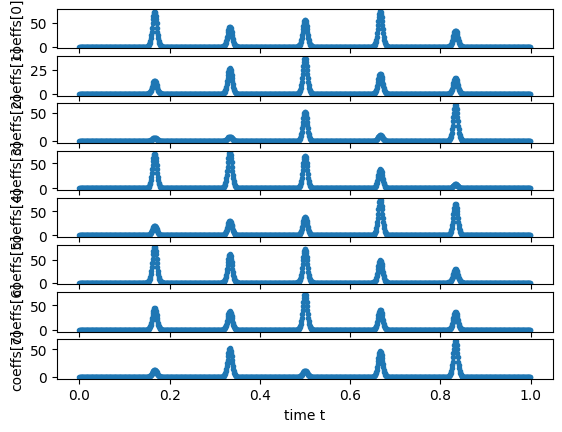

In [4]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [5]:
from datetime import datetime

def train(param_vector, n_epochs, lr):

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(param_vector)

    energy = np.zeros(n_epochs + 1)
    energy[0] = loss(param_vector)
    mean_gradients = np.zeros(n_epochs)
    param_trajectory = []

    ## Optimization loop
    for n in range(n_epochs):
        val, grads = value_and_grad(param_vector)
        updates, opt_state = optimizer.update(grads, opt_state)
        param_vector = optax.apply_updates(param_vector, updates)

        mean_gradients[n] = np.mean(np.abs(grads))
        energy[n+1] = val

        # print(f"            param: {param_vector}")

        if not n % 10:
            print(f"        {n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
            print(f"        mean grad: {mean_gradients[n]}")



    print(f"Found ground state: {energy[-1]}")

    return energy, param_trajectory, mean_gradients


In [6]:
epochs_array = jnp.array([60, 70, 80, 90, 100, 110])
lr_array = jnp.logspace(-1, 1, num=15)
lr_array

Array([ 0.1       ,  0.13894955,  0.19306977,  0.26826958,  0.37275937,
        0.51794747,  0.71968567,  1.        ,  1.38949549,  1.93069773,
        2.6826958 ,  3.72759372,  5.17947468,  7.19685673, 10.        ],      dtype=float64)

In [7]:
final_loss_matrix = jnp.zeros((epochs_array.shape[0],lr_array.shape[0]))
final_loss_matrix

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float64)

In [8]:
final_loss_matrix = np.zeros((epochs_array.shape[0],lr_array.shape[0]))


for j in range(len(epochs_array)):
    for k in range(len(lr_array)):

        epochs = epochs_array[j],
        lr = lr_array[k]
        print(lr)

        param_vector = perceptron.get_random_parameter_vector(0)

        energy, a, b = train(param_vector, int(epochs[0]), float(lr))

        final_energy = energy[-1]

        final_loss_matrix[j,k] = final_energy

        print(f' Epochs: {epochs} | lr: {lr} | Final Loss: {final_energy}')

0.1
        1 / 60; energy discrepancy: 7.451423165666627
        mean grad: 0.5956307109854962
        11 / 60; energy discrepancy: 4.643541807826742
        mean grad: 0.5201440826247875
        21 / 60; energy discrepancy: 2.1378791234285695
        mean grad: 0.7904379570561584
        31 / 60; energy discrepancy: 6.178082930743254
        mean grad: 0.37026315287563843
        41 / 60; energy discrepancy: 1.4068225967269061
        mean grad: 0.3313454305918205
        51 / 60; energy discrepancy: 4.478684873532177
        mean grad: 0.38352348609136283
Found ground state: -1.3697035135060371
 Epochs: (Array(60, dtype=int64),) | lr: 0.1 | Final Loss: -1.3697035135060371
0.13894954943731375
        1 / 60; energy discrepancy: 7.451423165666627
        mean grad: 0.5956307109854962
        11 / 60; energy discrepancy: 5.42391162410355
        mean grad: 0.6096477603253568
        21 / 60; energy discrepancy: 1.9512733255575645
        mean grad: 0.616724707392071
        31 / 60; en

In [22]:
final_loss_matrix

tensor([[ 7.00000069,  7.00000085, -6.83236882, -7.00214234, -6.99737482,
         -5.11984822, -5.1157946 , -6.98700281, -6.17822211, -3.89208867,
         -0.78706548, -1.92026437, -0.20892967, -0.33130322, -0.10748953],
        [ 7.00000042,  6.99999957,  0.03502867, -7.0165844 , -7.00768239,
         -5.12242801, -5.11748218, -7.00236949, -6.4990034 , -4.38323529,
          0.35733094,  0.03676681, -0.07386132,  0.42122675,  0.08234379],
        [ 7.00000067,  7.0000001 , -1.25525815, -7.02073909, -7.01262016,
         -5.12493239, -5.10060354, -7.0099987 , -6.86718792, -4.85160836,
         -2.00595839, -1.91966023, -0.96645703,  0.20194148, -0.99082749],
        [ 7.00000594,  6.99999881,  6.9999996 , -6.94833166, -7.01523676,
         -5.12585964, -5.11895912, -7.0065327 , -6.92846441, -5.02347755,
          0.41498431,  0.32496089, -0.20572689, -0.15867323, -0.11026981],
        [ 7.00000058, -3.45509337,  6.99999902, -6.89339139, -7.01645835,
         -5.12621698, -5.12609999,

In [34]:
best_loss_ind = np.unravel_index(np.argmin(final_loss_matrix, axis=None), final_loss_matrix.shape)
best_loss = final_loss_matrix[best_loss_ind]


In [36]:
best_epoch_n = epochs_array[best_loss_ind[0]]
best_lr =lr_array[best_loss_ind[1]]

print(best_loss)
print(best_epoch_n)
print(best_lr)

-7.020739092086382
80
0.2682695795279726


In [ ]:
from datetime import datetime

n_epochs = 100
param_vector = perceptron.get_random_parameter_vector(0)

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(1e-1)
# schedule1 = optax.constant_schedule(5e-1)
# schedule = optax.join_schedules([schedule0, schedule1], [20])
# optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energy = np.zeros(n_epochs + 1)
energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(param_vector)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)
    param_vector = optax.apply_updates(param_vector, updates)

    mean_gradients[n] = np.mean(np.abs(grads))
    energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")



print(f"Found ground state: {energy[-1]}")
